In [286]:
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import scipy as sc
import numpy as np

In [51]:
sns.set(font='DejaVu Sans',
        rc={
 'axes.axisbelow': False,
 'axes.edgecolor': 'lightgrey',
 'axes.facecolor': 'None',
 'axes.grid': False,
 'grid.color': '.8',
 'axes.labelcolor': 'dimgrey',
 'axes.spines.right': False,
 'axes.spines.top': False,
 'figure.facecolor': 'white',
 'lines.solid_capstyle': 'round',
 'patch.edgecolor': 'w',
 'patch.force_edgecolor': True,
 'text.color': 'dimgrey',
 'xtick.bottom': False,
 'xtick.color': 'dimgrey',
 'xtick.direction': 'out',
 'xtick.top': False,
 'ytick.color': 'dimgrey',
 'ytick.direction': 'out',
 'ytick.left': False,
 'ytick.right': False})
sns.set_context("notebook", rc={"font.size":10,
                                "axes.titlesize":12,
                                "axes.labelsize":10})
sns.set_palette("colorblind")

In [226]:
# Load data set
dataset = sc.io.loadmat('./Dataset1.mat')

In [227]:
# Retrieve data
data = dataset['R']
direction = dataset['direction'].reshape(158,)

## Visualize data (for fun)

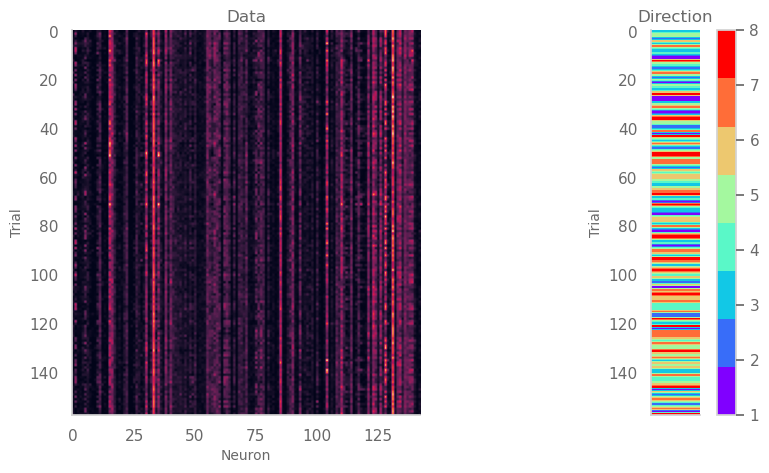

In [374]:
colors = plt.cm.rainbow(np.linspace(0, 1, 8))
cmap = ListedColormap(colors)


fig = plt.figure(figsize = (9,5))
fig.subplots_adjust(wspace = 0)

plt.subplot(121)

plt.imshow(data.T)
plt.xlabel('Neuron')
plt.ylabel('Trial')
plt.title('Data')

plt.subplot(122)
plt.imshow(direction.reshape(158,1), aspect = 0.05, cmap = cmap)
plt.title('Direction')
plt.ylabel('Trial')
plt.xticks([])
plt.colorbar()

plt.show()

## Mean firing rate of first neuron at each direction 
Error bars ar `sd` and `sem`, respectively

In [6]:
meanFiring = []
sdFiring = []
seFiring = []
for i in range(1, 9): # Moving along 'directions'
    # data[0] is the first neuron at i direction
    meanFiring.append(np.mean(data[0][direction == i]))
    sdFiring.append(np.std(data[0][direction == i]))
    seFiring.append(sc.stats.sem(data[0][direction == i]))

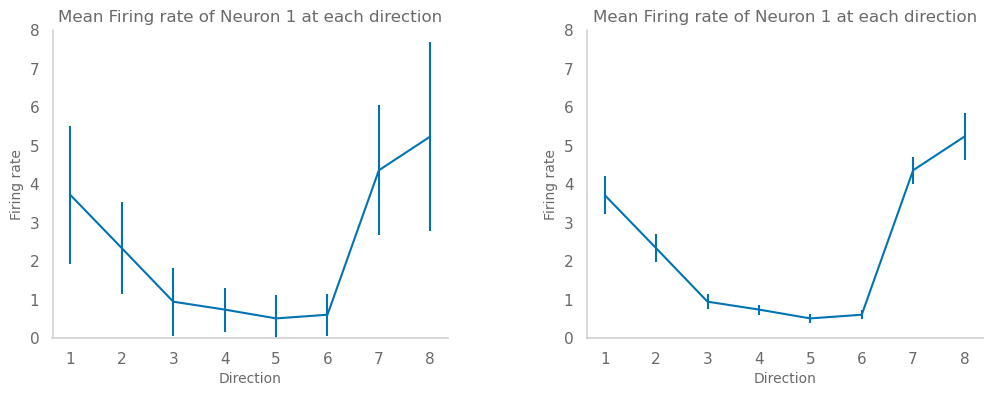

In [7]:
fig = plt.figure(figsize = (12,4))
fig.subplots_adjust(hspace=0.4, wspace=0.35)

plt.subplot(121)

plt.errorbar([i + 1 for i in range(8)], meanFiring, yerr = sdFiring)
plt.title('Mean Firing rate of Neuron 1 at each direction')
plt.xlabel('Direction')
plt.ylabel('Firing rate')
plt.ylim(0, 8)

plt.subplot(122)
plt.errorbar([i + 1for i in range(8)], meanFiring, yerr = seFiring)
plt.title('Mean Firing rate of Neuron 1 at each direction')
plt.xlabel('Direction')
plt.ylabel('Firing rate')
plt.ylim(0, 8)

plt.show()

## Mean firing rate of first nine neurons at each direction
Error bars are `sd`

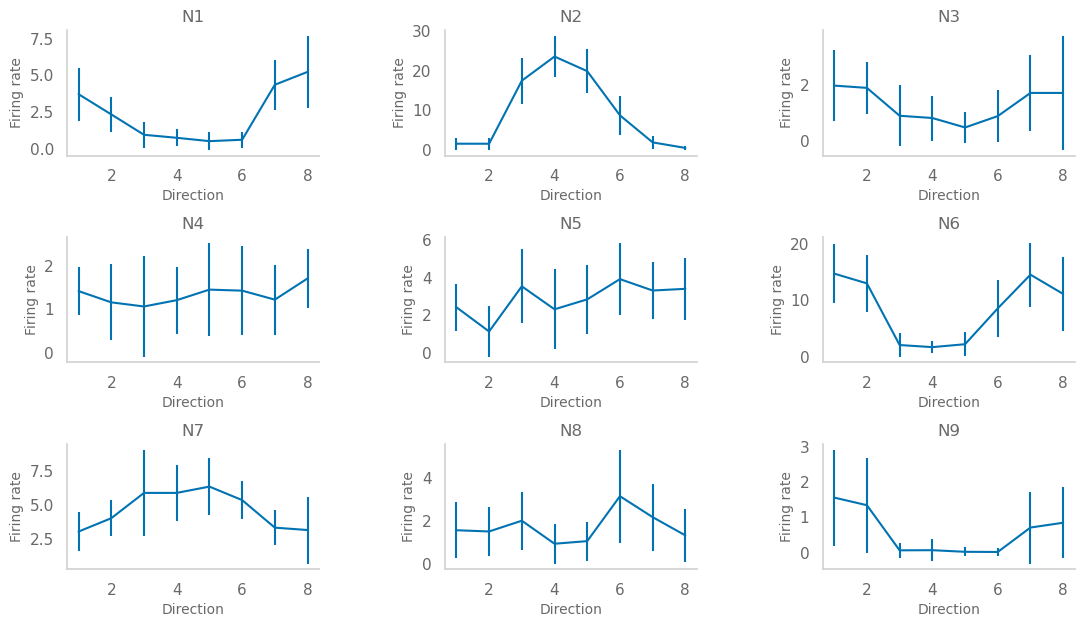

In [8]:
fig = plt.figure(figsize = (13,7))
fig.subplots_adjust(hspace = 0.65, wspace = 0.5)

# Same logic as previous chunk, but now, moving along first 9 neurons
for i in range(9):
    plt.subplot(331 + i)
    meanFiring = []
    sdFiring = []
    for j in range(1, 9):
        meanFiring.append(np.mean(data[i][direction == j]))
        sdFiring.append(np.std(data[i][direction == j]))
        seFiring.append(sc.stats.sem(data[i][direction == j]))
    plt.errorbar([k for k in range(1, 9)], meanFiring, yerr = sdFiring)
    plt.title('N{}'.format(i + 1))
    #plt.title('Mean Firing rate N{} \n for each direction'.format(i + 1))
    plt.xlabel('Direction')
    plt.ylabel('Firing rate')
    #plt.ylim(0, 8)
plt.show()

## Quantifying the uncertainty in the firing rate via Bootstrapping

In [9]:
nNeurons = data.shape[0]
nTrials = data.shape[1]
nBootstraps = 1e4

# Bootstrapping
firingRate_Bootstraps = []
for i in range(int(nBootstraps)):
    # Randomly select subset of 'Trials' with replacement
    bootstrapIndices = np.random.choice(nTrials, size = nTrials, replace = True)
    bootstrapData = data[:, bootstrapIndices]
    bootstrapDirection = direction[bootstrapIndices]
    
    # Calculate firing rate for each neuron for each direction
    firingRate_Bootstrap = []
    for d in range(1, 9):
        selectedTrials = bootstrapData[:, bootstrapDirection == d]
        firingRate = np.mean(selectedTrials, axis = 1)
        firingRate_Bootstrap.append(firingRate)
    
    firingRate_Bootstraps.append(firingRate_Bootstrap)
    
# Convert to np.array to easy on the statistics
firingRate_Bootstraps = np.array(firingRate_Bootstraps)

# Get statistics
meanFiring_rate = np.mean(firingRate_Bootstraps, axis = 0)
stdFiring_rate = np.std(firingRate_Bootstraps, axis = 0)
confidenceInterval = np.percentile(firingRate_Bootstraps, q = [2.5, 97.5], axis = 0)

## Visualize bootrapped values for first nine neurons

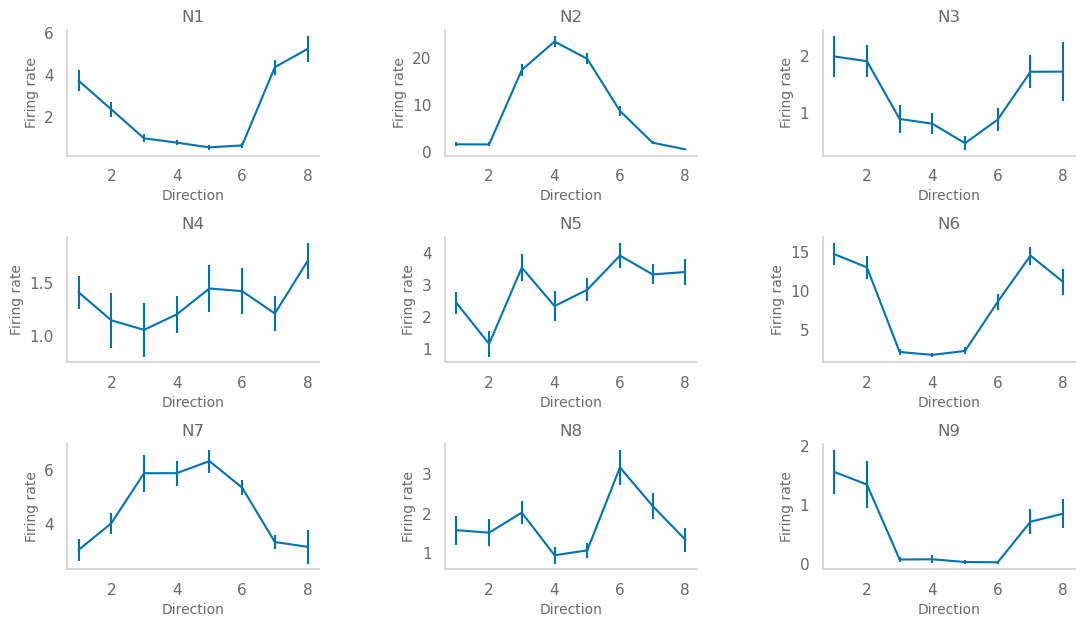

In [10]:
fig = plt.figure(figsize = (13,7))
fig.subplots_adjust(hspace = 0.65, wspace = 0.5)

# Same logic as previous chunk, but now, moving along first 9 neurons

for neuron in range(9):
    plt.subplot(331 + neuron)
    plt.errorbar([i + 1 for i in range(8)], meanFiring_rate[:, neuron], yerr = stdFiring_rate[:, neuron])
    plt.title('N{}'.format(neuron + 1))
    #plt.title('Mean Firing rate N{} \n for each direction'.format(i + 1))
    plt.xlabel('Direction')
    plt.ylabel('Firing rate')
    #plt.ylim(0, 8)
plt.show()

### Converting our data to DF

In [11]:
data_Bootstraped = []
for neuron in range(nNeurons):
    for d in range(8):
        data_Bootstraped.append({
            'Neuron': neuron + 1,
            'Direction': d + 1,
            'Mean': meanFiring_rate[d, neuron],
            'Std': stdFiring_rate[d, neuron],
            'CI_Low (0.025)': confidenceInterval[0, d, neuron],
            'CI_High (0.975)': confidenceInterval[1, d, neuron]})

df = pd.DataFrame(data_Bootstraped)

In [12]:
df.head(16)

,Neuron,Direction,Mean,Std,CI_Low (0.025),CI_High (0.975)
0,1,1,3.717931,0.499245,2.768539,4.734460
1,1,2,2.341287,0.356238,1.603183,3.038114
2,1,3,0.950171,0.193259,0.586075,1.335122
3,1,4,0.745156,0.130135,0.490555,1.011361
4,1,5,0.516263,0.121254,0.293676,0.768421
5,1,6,0.610814,0.114105,0.403849,0.854455
6,1,7,4.365464,0.354200,3.722565,5.114854
7,1,8,5.242244,0.622714,4.080650,6.501475
8,2,1,1.535852,0.437287,0.769127,2.483387
9,2,2,1.523346,0.443288,0.785922,2.504869


In [13]:
df.tail(16)

,Neuron,Direction,Mean,Std,CI_Low (0.025),CI_High (0.975)
1128,142,1,1.080737,0.186980,0.736693,1.462599
1129,142,2,0.622605,0.153632,0.321277,0.922980
1130,142,3,1.516732,0.235552,1.076824,1.988616
1131,142,4,1.235557,0.176091,0.904792,1.601218
1132,142,5,1.094617,0.129197,0.848954,1.357014
1133,142,6,0.779353,0.132854,0.532438,1.061449
1134,142,7,0.641520,0.090488,0.466155,0.816156
1135,142,8,0.622350,0.186450,0.272129,1.008334
1136,143,1,4.312417,0.583320,3.202669,5.480683
1137,143,2,2.704676,0.437202,1.840027,3.551222


<div style="background-color:#B43757; color:white; padding:10px;">
<left>
</div>

In [5]:
# we will use the tutorial from https://lmfit.github.io/lmfit-py/model.html :
from lmfit import Model, Parameters

In [6]:
# https://en.wikipedia.org/wiki/Von_Mises_distribution
def tuning_function(theta, theta0, kappa, fmax, bsl, theta_bound):
    # Von Mises, with kappa the concentration, theta0 the location
    # fmax the firing rate at pref ori, bsl the min firing rate (not the baseline, which was substracted) 
    tf = bsl + np.exp(kappa*(np.cos(2*np.pi/theta_bound*(theta-theta0))-1)) * (fmax-bsl)
    return tf

def fit_tc(array, init_kappa, theta_bound = 2*np.pi):
    """
    Fits the data points in `array` to `tuning_function`.
    
    set theta_bound to 2*np.pi for fitting signed angles (eg direction)
    or to np.pi for an unsigned one (like orientation)
    """
              
    theta = np.linspace(0, theta_bound, len(array), endpoint=False)
    mod = Model(tuning_function)
    pars = Parameters()
    #               name    default           vary  min   max
    pars.add_many(('theta0', theta[np.argmax(array)], True, 0., theta_bound),
                  ('kappa', init_kappa, True,  .1, 5.),
                  ('fmax', np.max(array), True, 0.0, 2*np.max(array)+5),
                  ('bsl', np.min(array), True, 0.0, np.max(array)+5),
                  ('theta_bound', theta_bound, False))
                
    out = mod.fit(array, pars, theta=theta, nan_policy='omit', max_nfev=50000)

    return out.best_values

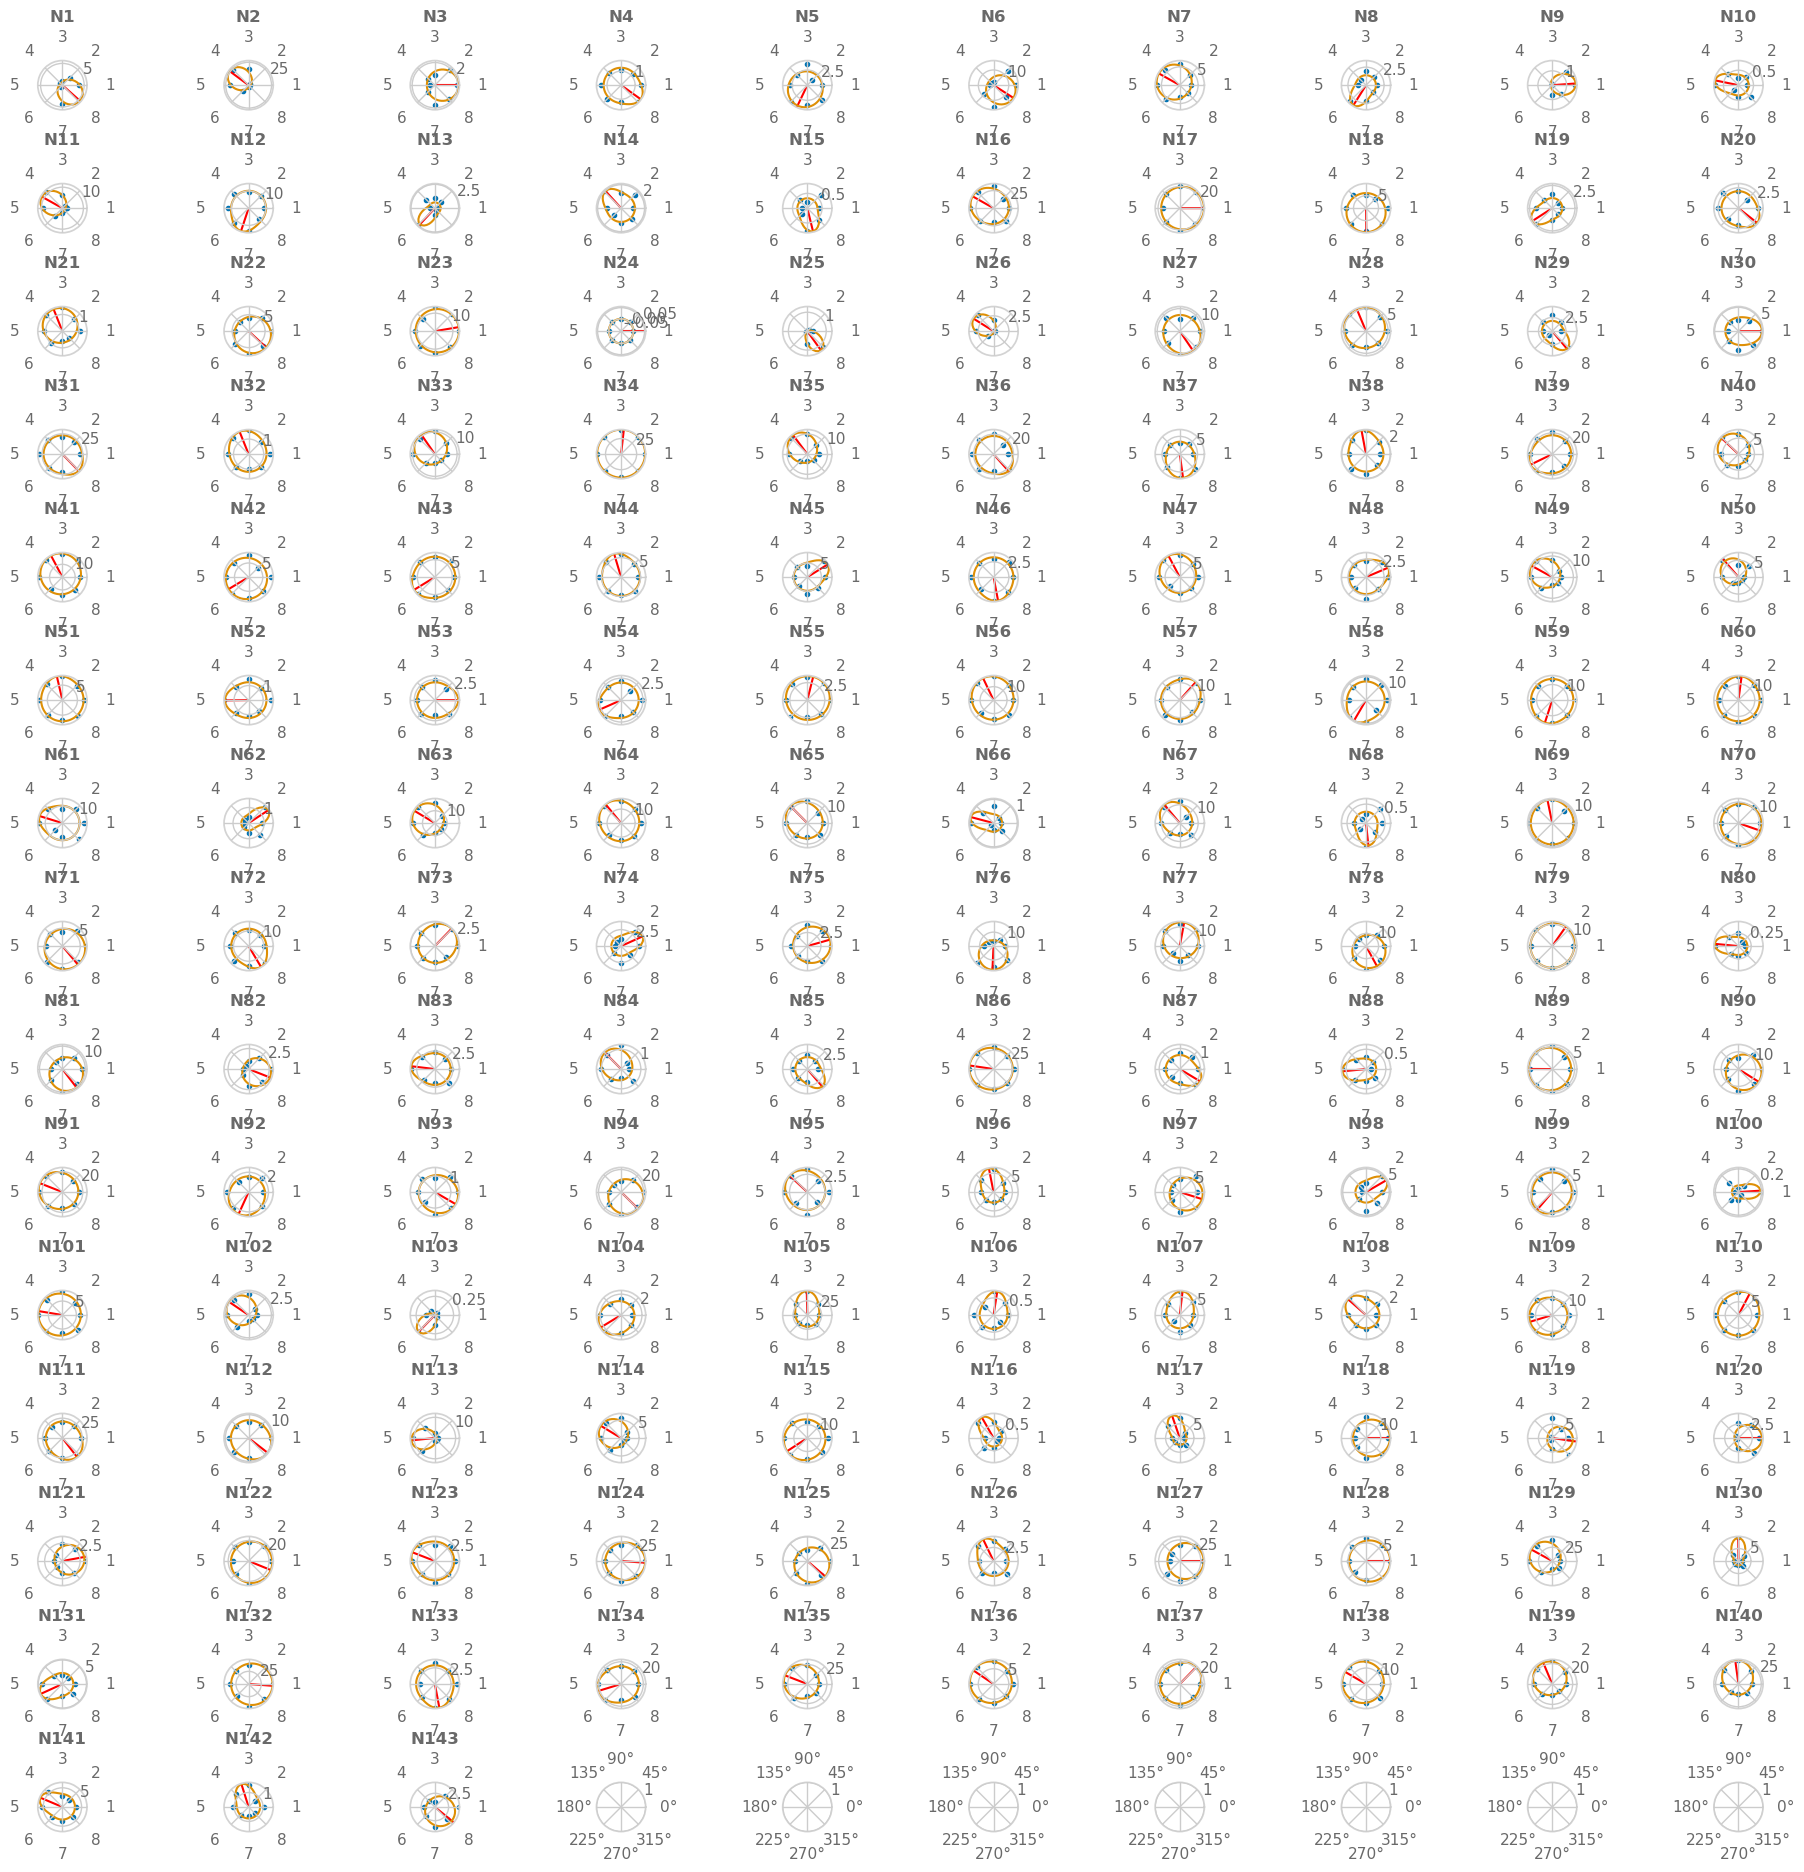

In [130]:
theta0_array = []
kappa_array = []
fmax_array = []
bsl_array = []

nNeurons = data.shape[0]
init_kappa = 3.5

fig, ax_array = plt.subplots(15, 10, figsize=(23, 23), squeeze = False, subplot_kw={'projection': 'polar'})
fig.subplots_adjust(hspace = 1.5, wspace = 0.75)

N_directions = 8
theta_bound = 2 * np.pi
theta = np.linspace(0, theta_bound, N_directions, endpoint = False)
theta_more = np.linspace(0, theta_bound, 60, endpoint = True)

for i, ax_row in enumerate(ax_array):
    for j, axes in enumerate(ax_row):
        neuron = (10 * i) + j
        # print(neuron)
        if neuron > nNeurons - 1:
            break
        
        ########################
        # Retrieve Firing rates for each neuron at each direction
        meanFiring = []
        #sdFiring = []
        #seFiring = []
        for k in range(1, 9): # Moving along 'directions'
            # data[0] is the first neuron at i direction
            meanFiring.append(np.mean(data[neuron][direction == k]))
            #sdFiring.append(np.std(data[neuron][direction == i]))
            #seFiring.append(sc.stats.sem(data[neuron][direction == i]))
        meanFiring = np.array(meanFiring)
        
        ########################
        # Retrieve Firing rates for each neuron at each direction
        
        fitted_params = fit_tc(meanFiring, init_kappa = init_kappa)
        
        
        #######
        # Saving parameters
        theta0_array.append(fitted_params['theta0'])
        kappa_array.append(fitted_params['kappa'])
        fmax_array.append(fitted_params['fmax'])
        bsl_array.append(fitted_params['bsl'])
        ########################
        # Plotting each fit
        
        axes.plot(theta, np.array(meanFiring), '.')
        axes.axvline(fitted_params['theta0'], color = 'red')


        axes.plot(theta_more, tuning_function(theta_more, **fitted_params))

        axes.set_title('N{}'.format(neuron + 1), fontweight = 'bold')
        #axes.set_xlabel('Direction')
        #axes.set_ylabel('Mean firing rate')
        
        axes.set_xticks(theta, [i + 1 for i in range(8)])
plt.show()

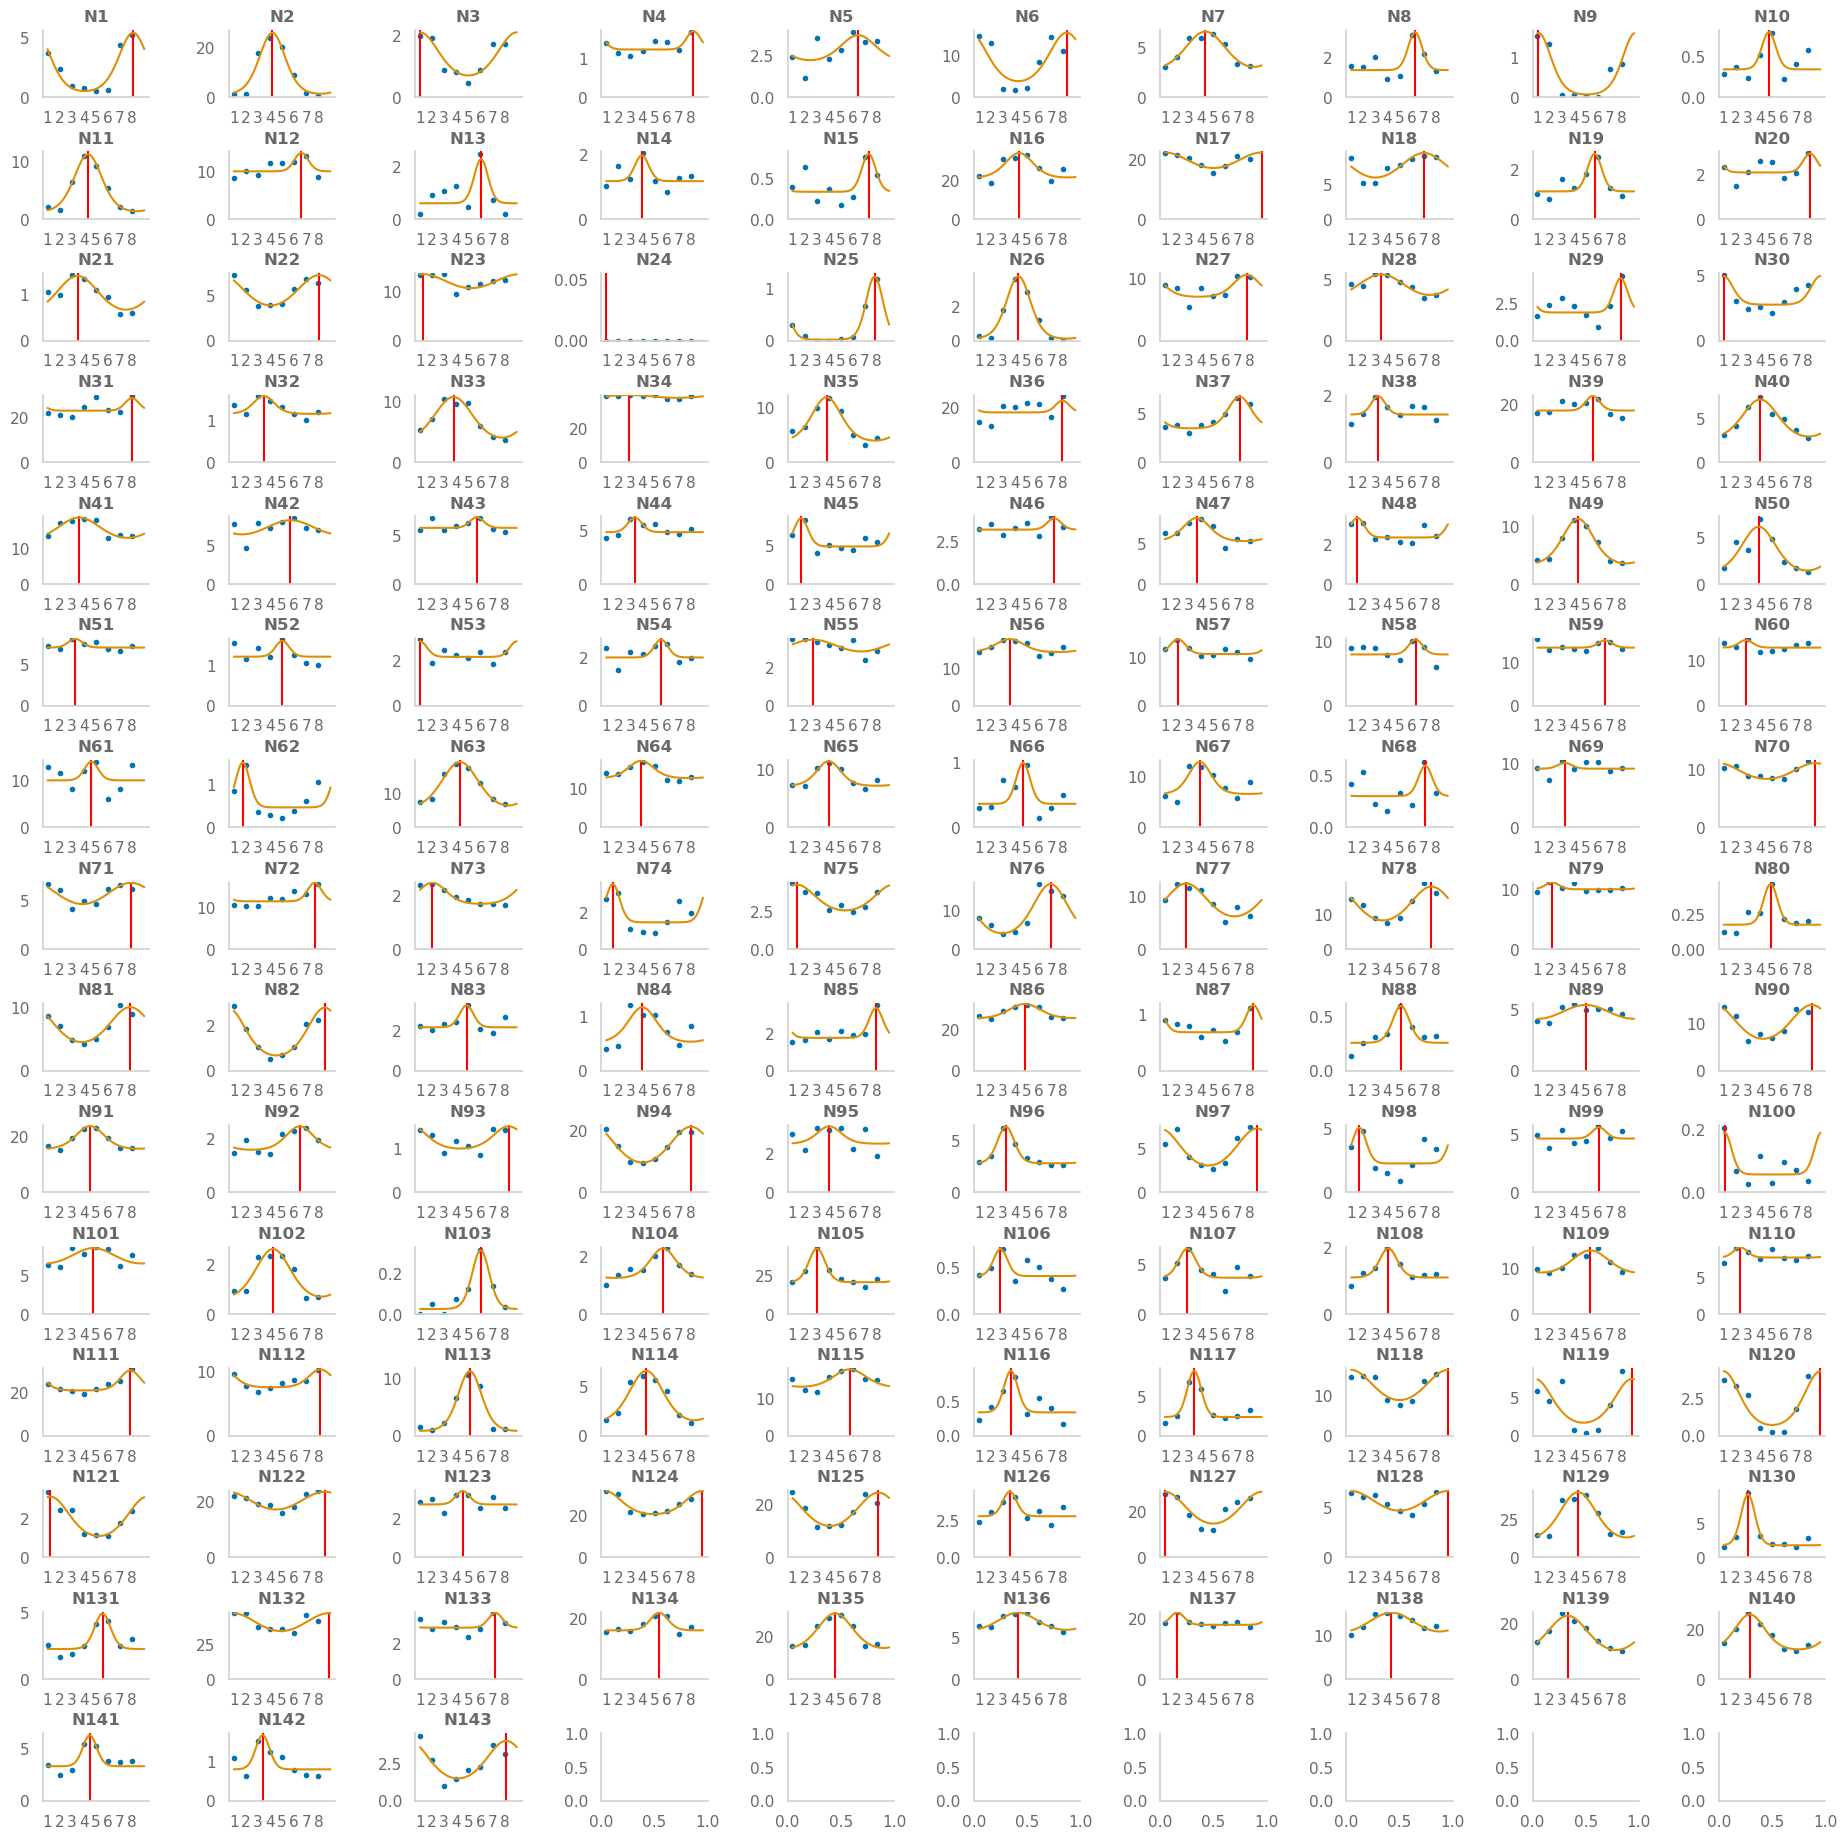

In [208]:
theta0_array = []
kappa_array = []
fmax_array = []
bsl_array = []

nNeurons = data.shape[0]
init_kappa = 3.5

fig, ax_array = plt.subplots(15, 10, figsize=(23, 23), squeeze = False)
fig.subplots_adjust(hspace = 0.8, wspace = 0.75)

N_directions = 8
theta_bound = 2 * np.pi
theta = np.linspace(0, theta_bound, N_directions, endpoint = False)
theta_more = np.linspace(0, theta_bound, 60, endpoint = True)

for i, ax_row in enumerate(ax_array):
    for j, axes in enumerate(ax_row):
        neuron = (10 * i) + j
        # print(neuron)
        if neuron > nNeurons - 1:
            break
        
        ########################
        # Retrieve Firing rates for each neuron at each direction
        meanFiring = []
        #sdFiring = []
        #seFiring = []
        for k in range(1, 9): # Moving along 'directions'
            # data[0] is the first neuron at i direction
            meanFiring.append(np.mean(data[neuron][direction == k]))
            #sdFiring.append(np.std(data[neuron][direction == i]))
            #seFiring.append(sc.stats.sem(data[neuron][direction == i]))
        meanFiring = np.array(meanFiring)
        
        ########################
        # Retrieve Firing rates for each neuron at each direction
        
        fitted_params = fit_tc(meanFiring, init_kappa = init_kappa)
        
        
        #######
        # Saving parameters
        theta0_array.append(fitted_params['theta0'])
        kappa_array.append(fitted_params['kappa'])
        fmax_array.append(fitted_params['fmax'])
        bsl_array.append(fitted_params['bsl'])
        ########################
        # Plotting each fit
        
        axes.plot(theta, np.array(meanFiring), '.')
        axes.axvline(fitted_params['theta0'], color = 'red')


        axes.plot(theta_more, tuning_function(theta_more, **fitted_params))

        axes.set_title('N{}'.format(neuron + 1), fontweight = 'bold')
        axes.set_ylim(bottom = 0)
        #axes.set_xlabel('Direction')
        #axes.set_ylabel('Mean firing rate')
        
        axes.set_xticks(theta, [i + 1 for i in range(8)])
plt.show()

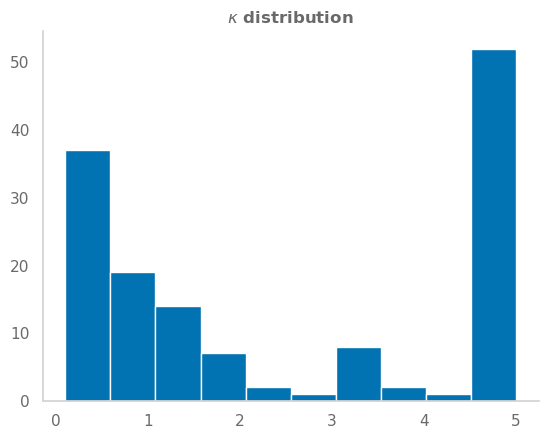

In [181]:
plt.hist(kappa_array)
plt.title('$\\kappa$ distribution', fontweight = 'bold')
plt.show()

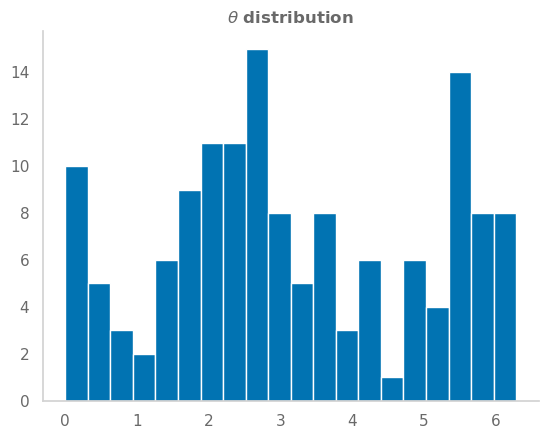

In [212]:
plt.hist(theta0_array, bins = 20)
plt.title('$\\theta$ distribution', fontweight = 'bold')
#plt.xticks(theta, [i + 1 for i in range(8)])
plt.show()

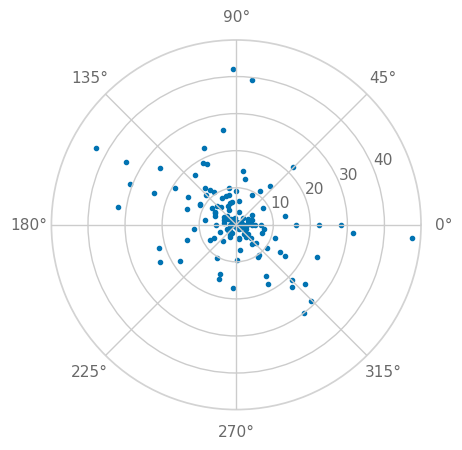

In [199]:
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})

ax.plot(theta0_array, fmax_array, '.')
plt.show()
#ax.set_rmax(2)
#ax.set_rticks([0.5, 1, 1.5, 2])  # Less radial ticks
#ax.set_rlabel_position(-22.5)  # Move radial labels away from plotted line
#ax.grid(True)

(array([10.,  5.,  3.,  2.,  6.,  9., 11., 11., 15.,  8.,  5.,  8.,  3.,
         6.,  1.,  6.,  4., 14.,  8.,  8.]),
 array([0.        , 0.31415927, 0.62831853, 0.9424778 , 1.25663706,
        1.57079633, 1.88495559, 2.19911486, 2.51327412, 2.82743339,
        3.14159265, 3.45575192, 3.76991118, 4.08407045, 4.39822971,
        4.71238898, 5.02654825, 5.34070751, 5.65486678, 5.96902604,
        6.28318531]),
 <BarContainer object of 20 artists>)

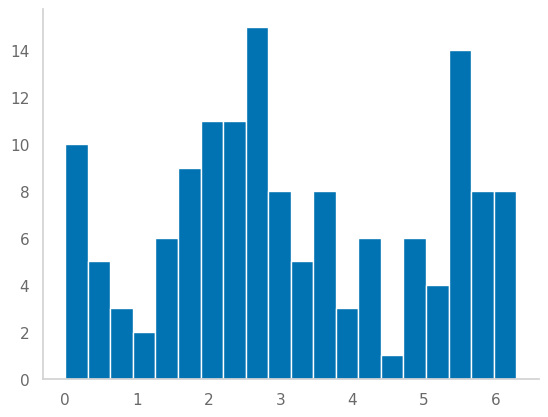

In [213]:
plt.hist(theta0_array, bins = 20)

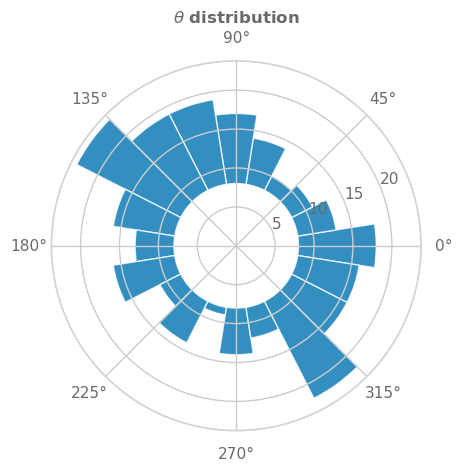

In [214]:
radii = [10.,  5.,  3.,  2.,  6.,  9., 11., 11., 15.,  8.,  5.,  8.,  3.,
         6.,  1.,  6.,  4., 14.,  8.,  8.]

angles = [0,0.31415927, 0.62831853, 0.9424778 , 1.25663706,
        1.57079633, 1.88495559, 2.19911486, 2.51327412, 2.82743339,
        3.14159265, 3.45575192, 3.76991118, 4.08407045, 4.39822971,
        4.71238898, 5.02654825, 5.34070751, 5.65486678, 5.96902604,]

width = (2*np.pi) / len(radii)

ax = plt.subplot(111, polar=True)
bars = ax.bar(angles, radii, width = width, bottom = bottom)

# Use custom colors and opacity
for r, bar in zip(radii, bars):
    #bar.set_facecolor(plt.cm.jet(r / 10.))
    bar.set_alpha(0.8)
ax.set_title('$\\theta$ distribution', fontweight = 'bold')

plt.show()

(array([10.,  5.,  3.,  2.,  6.,  9., 11., 11., 15.,  8.,  5.,  8.,  3.,
         6.,  1.,  6.,  4., 14.,  8.,  8.]),
 array([0.        , 0.31415927, 0.62831853, 0.9424778 , 1.25663706,
        1.57079633, 1.88495559, 2.19911486, 2.51327412, 2.82743339,
        3.14159265, 3.45575192, 3.76991118, 4.08407045, 4.39822971,
        4.71238898, 5.02654825, 5.34070751, 5.65486678, 5.96902604,
        6.28318531]),
 <BarContainer object of 20 artists>)

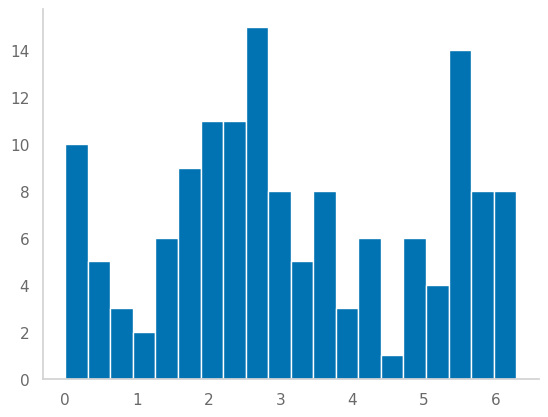

In [183]:
plt.hist(theta0_array, bins = 20)

In [188]:
len(angles)

21

In [116]:
#plt.hist(theta0_array)

#plt.hist(kappa_array)
#fmax_array
#bsl_array 

<div style="background-color:#B43757; color:white; padding:10px;">
<left>
</div>

## Neuron 1 vs Neuron 2

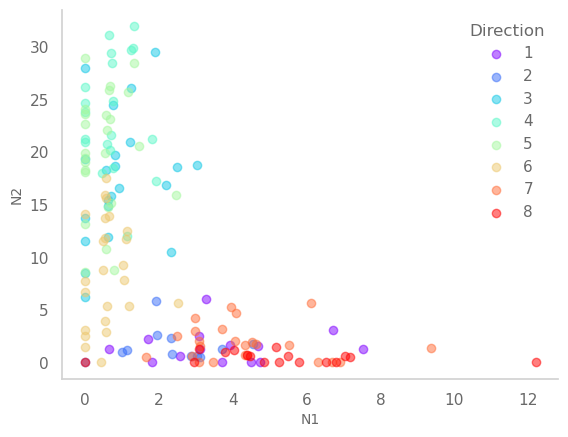

In [31]:
n1, n2 = 0, 1
for i in range(1, 9):
    plt.scatter(data[n1][direction == i], data[n2][direction == i], alpha = 0.5, label = '{}'.format(i), color = colors[i - 1])
plt.xlabel('N{}'.format(n1 + 1))
plt.ylabel('N{}'.format(n2 + 1))
plt.legend(title = 'Direction', frameon = False)
plt.show()

array([[ 2.71265617e+00,  3.12478467e+00,  7.07213234e-01, ...,
        -4.15900297e-01, -1.39436149e+00, -2.86416118e-02],
       [ 5.33178086e+00, -7.10052396e-01, -2.42297617e+00, ...,
        -1.53720474e-02,  1.16941826e+00,  3.97228947e+00],
       [ 4.61669613e+00, -6.88389555e-01, -1.66369178e+00, ...,
        -9.49994305e-01, -1.06845209e+00,  1.28194466e+00],
       ...,
       [-7.25258704e+00, -4.30673906e-01, -1.97465030e+00, ...,
        -7.10778809e-01,  3.48154171e+00,  1.75430213e-01],
       [-4.63730336e+00,  2.06261133e+00, -1.40104397e+00, ...,
         1.27735190e+00, -5.24405769e-03, -8.62791251e-01],
       [-5.81857718e+00, -8.19069425e-01, -5.71114227e-01, ...,
        -3.37790742e-01,  2.17822209e+00,  6.83050079e-01]])

## PCA

But before... Standarization

Proceed with the PCA

In [325]:
scaler = StandardScaler()
scaledData = scaler.fit_transform(data.T) # Should I transpose? After one dim inconsistency, I did

In [320]:
nComponents = 10
pca = PCA(n_components = nComponents)
pca.fit(scaledData)

PCA(n_components=10)

In [321]:
# Transform the scaled data to the principal components
data_t = pca.transform(scaledData)

# Explained variance ratio of each component
explained_variance_ratio = pca.explained_variance_ratio_

# Principal components (eigenvectors)
principal_components = pca.components_

# Singular values
singular_values = pca.singular_values_

# Print the results
#print(principal_components)
#print("Singular Values:", singular_values)
print("Transformed Data Shape:", data_t.shape)

Transformed Data Shape: (158, 10)


In [287]:
principal_components.shape

(2, 143)

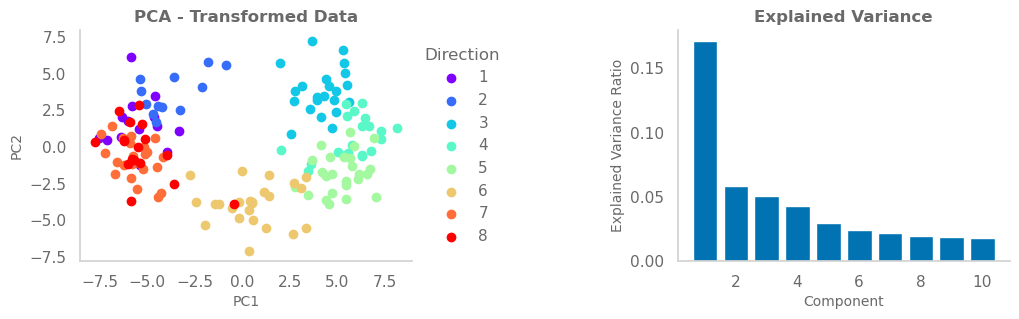

In [322]:
fig = plt.figure(figsize = (12,3))
fig.subplots_adjust(wspace = 0.8)

plt.subplot(121)
for d in range(8):
    mask = (direction == d + 1)
    plt.scatter(data_t[mask, 0], data_t[mask, 1], color = colors[d], label = '{}'.format(d + 1))

plt.title('PCA - Transformed Data', fontweight = 'bold')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend(loc = 'center', bbox_to_anchor = (1.15, 0.5), title = 'Direction', frameon = False)

plt.subplot(122)
plt.bar([i + 1 for i in range(nComponents)], pca.explained_variance_ratio_)
plt.title('Explained Variance', fontweight = 'bold')
plt.xlabel('Component')
plt.ylabel('Explained Variance Ratio')
plt.show()

In [323]:
pca.explained_variance_ratio_[:2].sum()

0.22965249641351987

<div style="background-color:#B43757; color:white; padding:10px;">
<left>
</div>

In [268]:
nNeurons

143

In [331]:
allDirections = []

for neuron in range(nNeurons):
    meanFiring = []
    for i in range(1, 9):
        meanFiring.append(np.mean(data[neuron][direction == i]))
    allDirections.append(meanFiring)
allDirections = np.array(allDirections)

In [332]:
allDirections.shape

(143, 8)

In [335]:
scaledData_reduced = scaler.fit_transform(allDirections.T) # Should I transpose? After one dim inconsistency, I did
nComponents = 2
pca = PCA(n_components = nComponents)
pca.fit(scaledData_reduced)
# Transform the scaled data to the principal components
data_t_reduced = pca.transform(scaledData_reduced)

# Explained variance ratio of each component
explained_variance_ratio = pca.explained_variance_ratio_

# Principal components (eigenvectors)
principal_components = pca.components_

# Singular values
singular_values = pca.singular_values_

# Print the results
#print(principal_components)
#print("Singular Values:", singular_values)
print("Transformed Data Shape:", data_t.shape)

Transformed Data Shape: (8, 2)


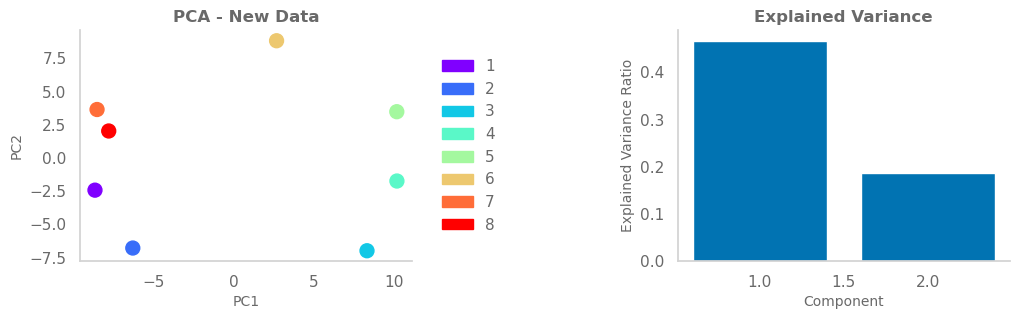

In [336]:
fig = plt.figure(figsize = (12,3))
fig.subplots_adjust(wspace = 0.8)

plt.subplot(121)
plt.scatter(data_t_reduced[:, 0], data_t_reduced[:, 1], color = colors, s = 1e2)


plt.title('PCA - New Data', fontweight = 'bold')
plt.xlabel('PC1')
plt.ylabel('PC2')

# Add legends as style (this can be ommited)
handles = []
for i in range(8):
    exec('patch{} = mpatches.Patch(color = colors[{}], label =  "{}")'.format(i + 1, i, i + 1))
    handles.append(eval('patch{}'.format(i + 1)))

plt.legend(handles = handles, loc = 'center left', bbox_to_anchor = (1.05, 0.5), frameon = False)

#plt.legend(loc = 'center', bbox_to_anchor = (1.15, 0.5), title = 'Direction', frameon = False)

plt.subplot(122)
plt.bar([i + 1 for i in range(nComponents)], pca.explained_variance_ratio_)
plt.title('Explained Variance', fontweight = 'bold')
plt.xlabel('Component')
plt.ylabel('Explained Variance Ratio')
plt.show()

In [303]:
pca.transform(scaledData).shape

(158, 2)

## Proyecting data into components of submatrix

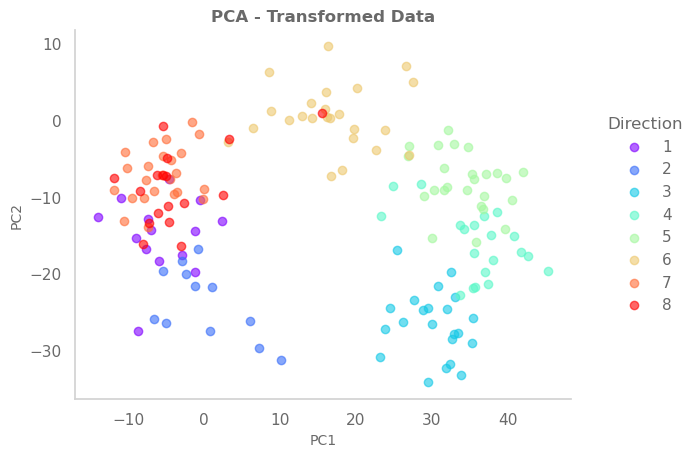

In [344]:
for d in range(8):
    mask = (direction == d + 1)
    plt.scatter(pca.transform(data.T)[:, 0][mask], pca.transform(data.T)[:, 1][mask], color = colors[d], label = '{}'.format(d + 1), alpha = 0.6)

plt.title('PCA - Transformed Data', fontweight = 'bold')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend(loc = 'center', bbox_to_anchor = (1.15, 0.5), title = 'Direction', frameon = False)
plt.show()

## Von Mises

In [364]:
allDirections_VM = []

init_kappa = 3.5

N_directions = 8
theta_bound = 2 * np.pi
theta = np.linspace(0, theta_bound, N_directions, endpoint = False)
theta_more = np.linspace(0, theta_bound, 60, endpoint = True)



for neuron in range(nNeurons):
        
        ########################
    # Retrieve Firing rates for each neuron at each direction
    meanFiring = []
    #sdFiring = []
    #seFiring = []
    for k in range(1, 9): # Moving along 'directions'
        # data[0] is the first neuron at i direction
        meanFiring.append(np.mean(data[neuron][direction == k]))
        #sdFiring.append(np.std(data[neuron][direction == i]))
        #seFiring.append(sc.stats.sem(data[neuron][direction == i]))
    meanFiring = np.array(meanFiring)

    ########################
    # Retrieve Firing rates for each neuron at each direction

    fitted_params = fit_tc(meanFiring, init_kappa = init_kappa)
    
    allDirections_VM.append(tuning_function(theta_more, **fitted_params))
allDirections_VM = np.array(allDirections_VM)

In [365]:
allDirections_VM.shape

(143, 60)

In [369]:
scaledData_reduced_VM = scaler.fit_transform(allDirections_VM.T) # Should I transpose? After one dim inconsistency, I did
nComponents = 2
pca = PCA(n_components = nComponents)
pca.fit(scaledData_reduced_VM)
# Transform the scaled data to the principal components
data_t_reduced_VM = pca.transform(scaledData_reduced_VM)

In [370]:
allDirections_VM.shape

(143, 60)

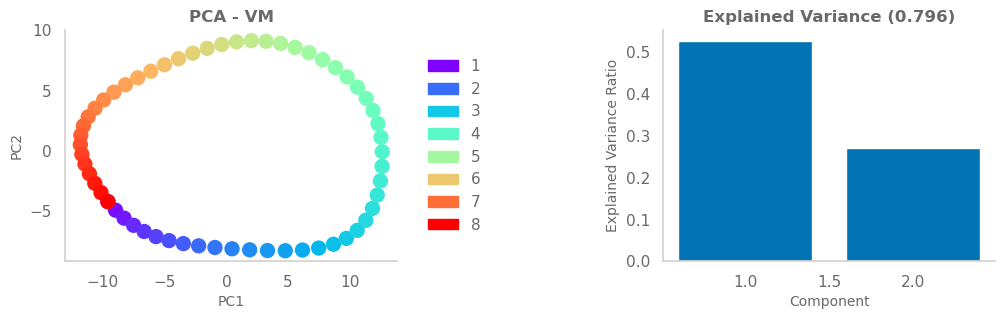

In [375]:
fig = plt.figure(figsize = (12,3))
fig.subplots_adjust(wspace = 0.8)

plt.subplot(121)
colors_m = plt.cm.rainbow(np.linspace(0, 1, len(theta_more)))
plt.scatter(data_t_reduced_VM[:, 0], data_t_reduced_VM[:, 1], color = colors_m, s = 1e2)


plt.title('PCA - VM', fontweight = 'bold')
plt.xlabel('PC1')
plt.ylabel('PC2')

# Add legends as style (this can be ommited)
handles = []
for i in range(8):
    exec('patch{} = mpatches.Patch(color = colors[{}], label =  "{}")'.format(i + 1, i, i + 1))
    handles.append(eval('patch{}'.format(i + 1)))

plt.legend(handles = handles, loc = 'center left', bbox_to_anchor = (1.05, 0.5), frameon = False)

#plt.legend(loc = 'center', bbox_to_anchor = (1.15, 0.5), title = 'Direction', frameon = False)

plt.subplot(122)
plt.bar([i + 1 for i in range(nComponents)], pca.explained_variance_ratio_)
plt.title('Explained Variance ({})'.format(round(pca.explained_variance_ratio_.sum(), 3)), fontweight = 'bold')
plt.xlabel('Component')
plt.ylabel('Explained Variance Ratio')
plt.show()

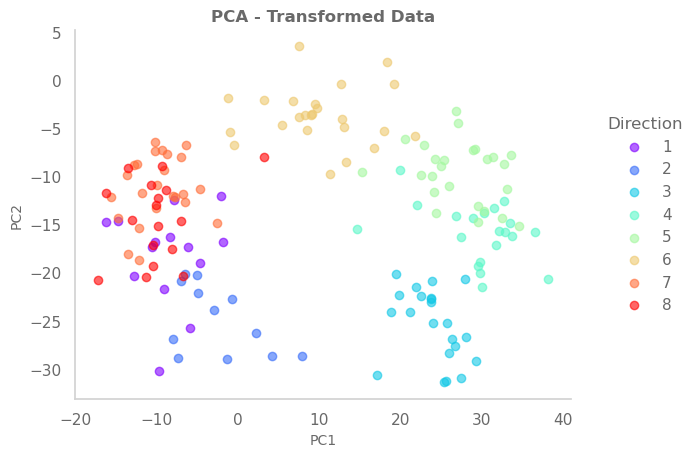

In [358]:
for d in range(8):
    mask = (direction == d + 1)
    plt.scatter(pca.transform(data.T)[:, 0][mask], pca.transform(data.T)[:, 1][mask], color = colors[d], label = '{}'.format(d + 1), alpha = 0.6)

plt.title('PCA - Transformed Data', fontweight = 'bold')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend(loc = 'center', bbox_to_anchor = (1.15, 0.5), title = 'Direction', frameon = False)
plt.show()

<div style="background-color:#B43757; color:white; padding:10px;">
<left>
</div>